In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import spacy
from textblob import TextBlob
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

# Download NLTK 

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Load the dataset

In [4]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

# Basic EDA

In [5]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample Data:")
display(df.head())

Dataset Shape: (50000, 2)

Columns: ['review', 'sentiment']

Sample Data:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Distribution of sentiment

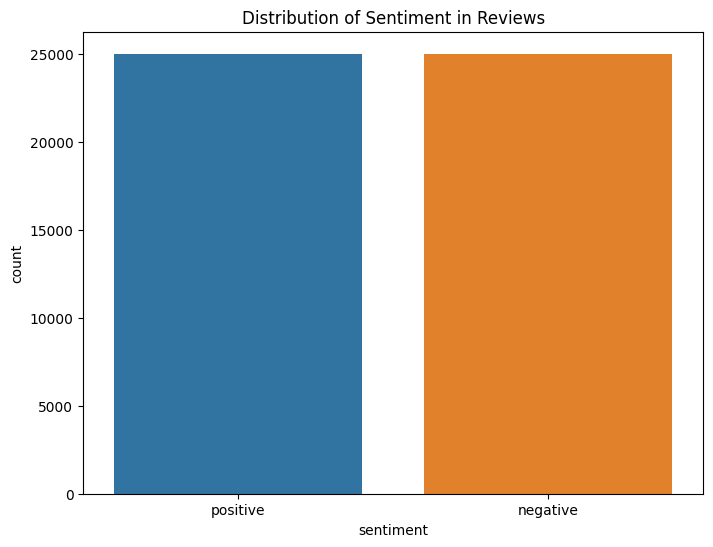

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Distribution of Sentiment in Reviews')
plt.show()

# Review length analysis

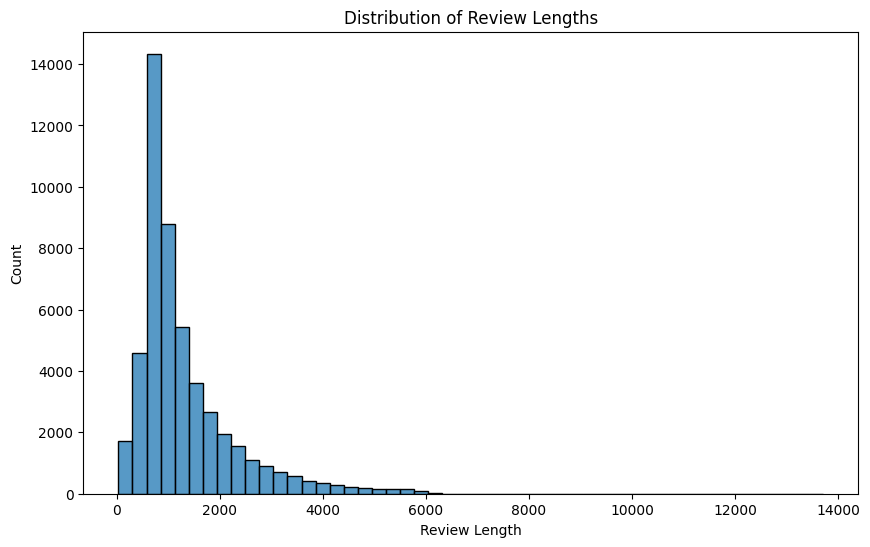

In [7]:
df['review_length'] = df['review'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='review_length', bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.show()

# Text Preprocessing Functions

In [9]:
def preprocess_text(text):
    """Master function to apply all preprocessing steps"""
    
    # 1. Lowercasing
    text = text.lower()
    
    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # 3. Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 5. Chat word treatment
    chat_words_dict = {
        "lol": "laugh out loud",
        "imho": "in my humble opinion",
        "tbh": "to be honest",
        # Add more chat words as needed
    }
    words = text.split()
    text = ' '.join([chat_words_dict.get(word, word) for word in words])
    
    # 6. Spelling correction (on a sample due to computational intensity)
    # text = str(TextBlob(text).correct())
    
    # 7. Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    
    # 8. Handle emojis
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    
    return text

# Apply preprocessing to reviews

In [10]:
print("Preprocessing reviews...")
df['processed_review'] = df['review'].apply(preprocess_text)

Preprocessing reviews...


# Tokenization

In [11]:
df['tokens'] = df['processed_review'].apply(word_tokenize)

# Stemming

In [12]:
porter = PorterStemmer()
df['stemmed'] = df['processed_review'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))

 # Feature Extraction

In [15]:
 # Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
bow_features = bow_vectorizer.fit_transform(df['processed_review'])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(df['processed_review'])

# N-grams (example with bigrams)
ngram_vectorizer = CountVectorizer(ngram_range=(2,2), max_features=5000)
ngram_features = ngram_vectorizer.fit_transform(df['processed_review'])

# Word2Vec

In [16]:
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=5)

# POS Tagging

In [18]:
def pos_tag_text(text):
    tokens = word_tokenize(text)
    return nltk.pos_tag(tokens)
    
# Apply POS tagging to a sample of reviews
df['pos_tags'] = df['processed_review'].head(1000).apply(pos_tag_text)

# Visualizations after preprocessing

# Word Cloud

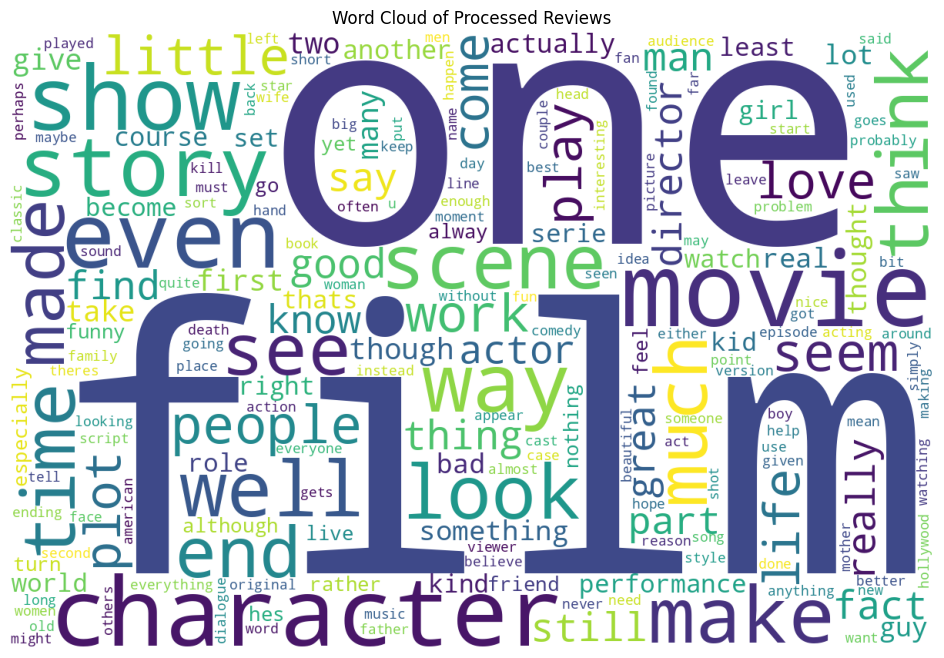

In [20]:
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(' '.join(df['processed_review']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Processed Reviews')
plt.show()

# Most common words

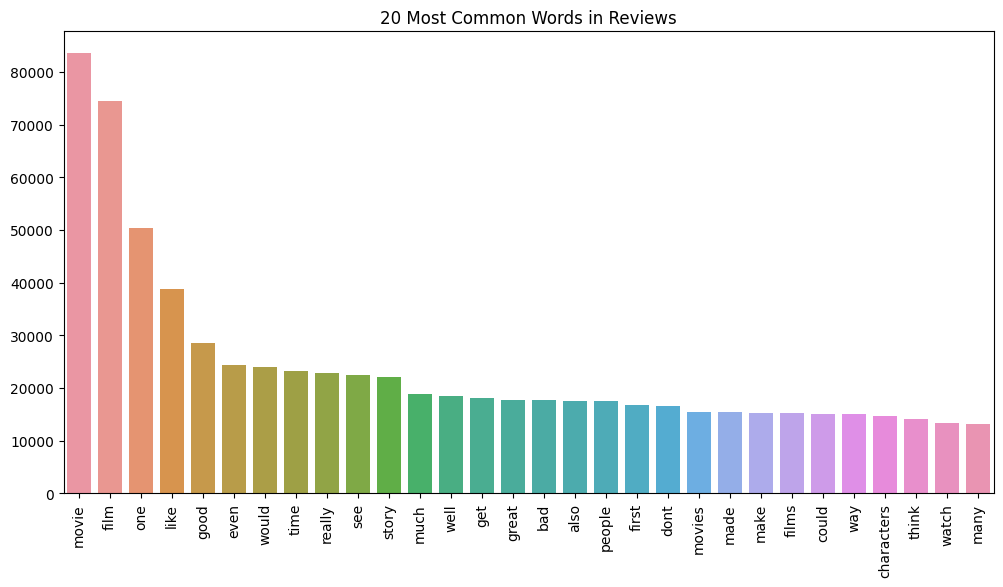

In [23]:
all_words = ' '.join(df['processed_review']).split()
word_freq = Counter(all_words).most_common(30)
words, freqs = zip(*word_freq)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(freqs))
plt.xticks(rotation=90)
plt.title('20 Most Common Words in Reviews')
plt.show()

# Average review length by sentiment

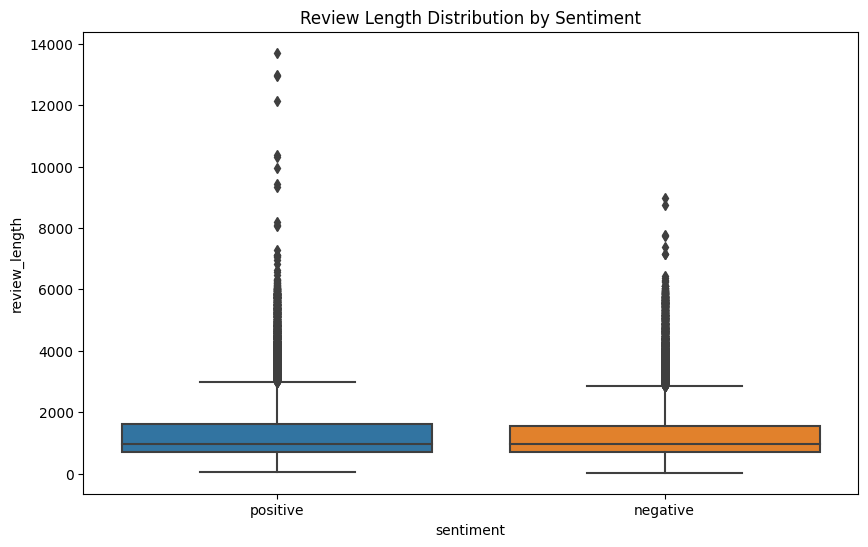

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='review_length')
plt.title('Review Length Distribution by Sentiment')
plt.show()


# POS Tag Distribution (for sample)

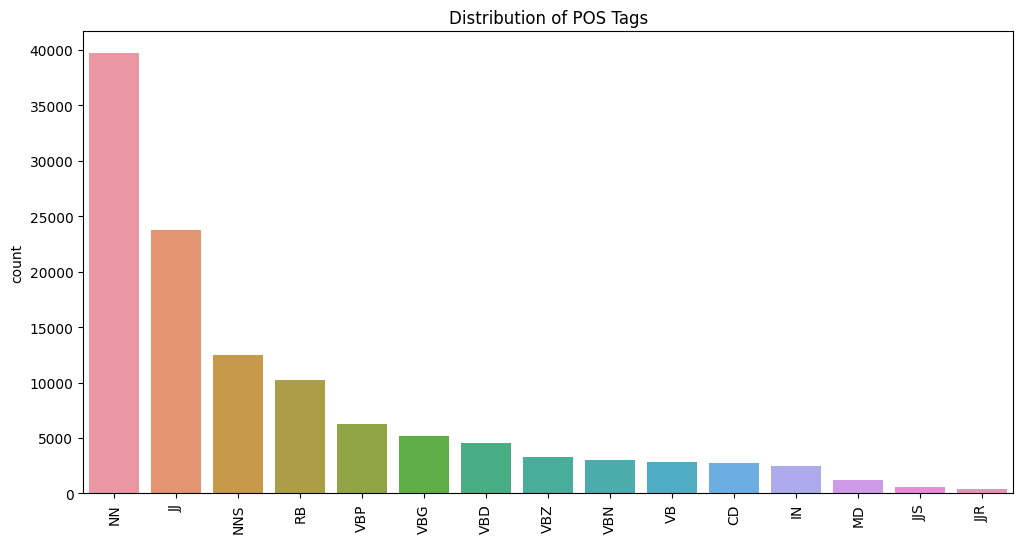

In [27]:
pos_counts = Counter([tag for review_tags in df['pos_tags'].dropna() for _, tag in review_tags])
pos_df = pd.DataFrame.from_dict(pos_counts, orient='index', columns=['count']).sort_values('count', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=pos_df.index, y='count', data=pos_df)
plt.xticks(rotation=90)
plt.title('Distribution of POS Tags')
plt.show()

# Feature importance using TF-IDF

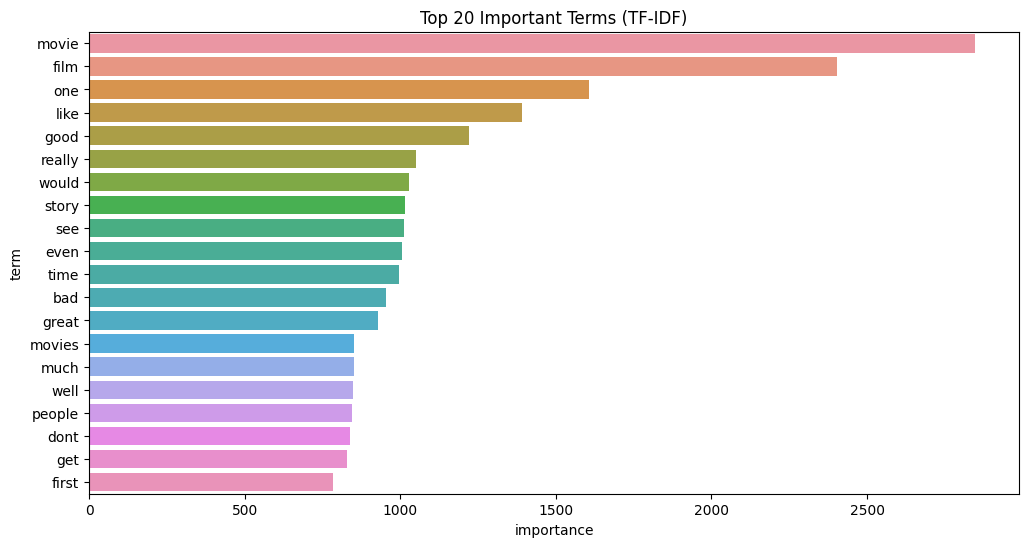

In [28]:
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_sums = tfidf_features.sum(axis=0).A1
top_features = pd.DataFrame({'term': feature_names, 'importance': tfidf_sums})
top_features = top_features.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='term', data=top_features)
plt.title('Top 20 Important Terms (TF-IDF)')
plt.show()